##6 - GoogLeNet

In the article, you will learn about how to implement the GoogLeNet(Inception v1) from the scratch based on the CUB200 datasets. The article will be organized in the following order:
* Dataset Preparation
* Building the GoogLeNet Model
* Defining the Optimizer
* Training
* Examination

As always, we will import the required modules here.

In [33]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import time
import copy

###1. Dataset Preparation

Here we will apply regular transformations (resize, totensor, normalization) & augmentations (rotation, horizontal_flip, crop) to the CIFAR100 datasets directly downloaded from torchvision.

In [2]:
pretrained_image_size = 224
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([transforms.Resize(pretrained_image_size),
                                      transforms.RandomRotation(5),
                                      transforms.RandomHorizontalFlip(0.5),
                                      transforms.RandomCrop(pretrained_image_size, padding=10),
                                      transforms.ToTensor(),
                                      transforms.Normalize(pretrained_means, pretrained_stds)])

test_transforms = transforms.Compose([transforms.Resize(pretrained_image_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize(pretrained_means, pretrained_stds)])

In [3]:
root = "data"
train_data = datasets.CIFAR100(root, train=True, transform=train_transforms, download=True)
test_data = datasets.CIFAR100(root, train=False, transform=test_transforms, download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


Then we will split the two datasets into train/dev/test sets.

In [4]:
TRAIN_RATIO = 0.9
n_train_examples = int(len(train_data) * TRAIN_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

In [5]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform=test_transforms

In [6]:
print(f"Training Data: {len(train_data)}")
print(f"Validation Data: {len(valid_data)}")
print(f"Testing Data: {len(test_data)}")

Training Data: 45000
Validation Data: 5000
Testing Data: 10000


Next, we'll create the iterators with the largest batch size that fits on our GPU.

In [7]:
BATCH_SIZE = 64

train_dataloader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_dataloader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

Finally we will visualize several examples from the training data to verify correctness of dataset preprocessing.

In [8]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image  

In [9]:
def plot_images(images, labels, classes, normalize = True):

  n_images = len(images)

  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure(figsize = (15, 15))

  for i in range(rows*cols):

    ax = fig.add_subplot(rows, cols, i+1)
        
    image = images[i]

    if normalize:
      image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    label = classes[labels[i]]
    ax.set_title(label)
    ax.axis('off')

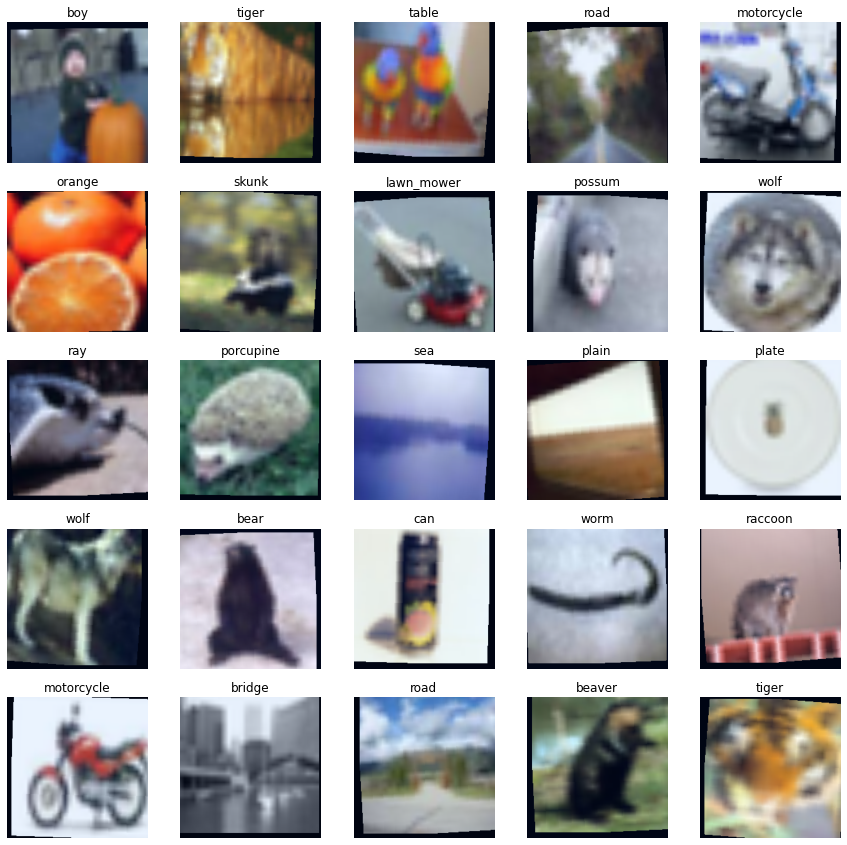

In [10]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

###2. Buiding the GoogLeNet Model

In [11]:
googlenet = models.googlenet(pretrained=True)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

![Structure of the Inception block. ](https://raw.githubusercontent.com/d2l-ai/d2l-en/master/img/inception.svg)

In [12]:
IN_FEATURES = googlenet.fc.in_features
OUT_FEATURES = len(test_data.classes)
googlenet.fc = nn.Linear(IN_FEATURES, OUT_FEATURES)
print(googlenet)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(googlenet):,} trainable parameters')

The model has 5,702,404 trainable parameters


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = googlenet.to(device)
loss_fn = nn.CrossEntropyLoss().to(device)

cuda


###3. Defining the Optimizer

In [15]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

In [16]:
from torch.optim.lr_scheduler import _LRScheduler

class LRFinder:
  def __init__(self, model, optimizer, criterion, device):
        
    self.optimizer = optimizer
    self.model = model
    self.criterion = criterion
    self.device = device
        
    torch.save(model.state_dict(), 'init_params.pt')

  def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
    lrs = []
    losses = []
    best_loss = float('inf')

    lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
    iterator = IteratorWrapper(iterator)
        
    for iteration in range(num_iter):

      loss = self._train_batch(iterator)

      #update lr
      lr_scheduler.step()
            
      lrs.append(lr_scheduler.get_lr()[0])

      if iteration > 0:
        loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
      if loss < best_loss:
        best_loss = loss

      losses.append(loss)
            
      if loss > diverge_th * best_loss:
        print("Stopping early, the loss has diverged")
        break
                       
    #reset model to initial parameters
    model.load_state_dict(torch.load('init_params.pt'))
                    
    return lrs, losses

  def _train_batch(self, iterator):
        
    self.model.train()
        
    self.optimizer.zero_grad()
        
    x, y = iterator.get_batch()
        
    x = x.to(self.device)
    y = y.to(self.device)
        
    y_pred = self.model(x)
                
    loss = self.criterion(y_pred, y)
        
    loss.backward()
        
    self.optimizer.step()
        
    return loss.item()

class ExponentialLR(_LRScheduler):
  def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
    self.end_lr = end_lr
    self.num_iter = num_iter
    super(ExponentialLR, self).__init__(optimizer, last_epoch)

  def get_lr(self):
    curr_iter = self.last_epoch + 1
    r = curr_iter / self.num_iter
    return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
  def __init__(self, iterator):
    self.iterator = iterator
    self._iterator = iter(iterator)

  def __next__(self):
    try:
      inputs, labels = next(self._iterator)
    except StopIteration:
      self._iterator = iter(self.iterator)
      inputs, labels, *_ = next(self._iterator)

    return inputs, labels

  def get_batch(self):
    return next(self)

In [17]:
END_LR = 10
NUM_ITER = 100

lr_finder = LRFinder(model, optimizer, loss_fn, device)
lrs, losses = lr_finder.range_test(train_dataloader, END_LR, NUM_ITER)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Stopping early, the loss has diverged


In [18]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
  if skip_end == 0:
    lrs = lrs[skip_start:]
    losses = losses[skip_start:]
  else:
    lrs = lrs[skip_start:-skip_end]
    losses = losses[skip_start:-skip_end]
    
  fig = plt.figure(figsize = (16,8))
  ax = fig.add_subplot(1,1,1)
  ax.plot(lrs, losses)
  ax.set_xscale('log')
  ax.set_xlabel('Learning rate')
  ax.set_ylabel('Loss')
  ax.grid(True, 'both', 'x')
  plt.show()

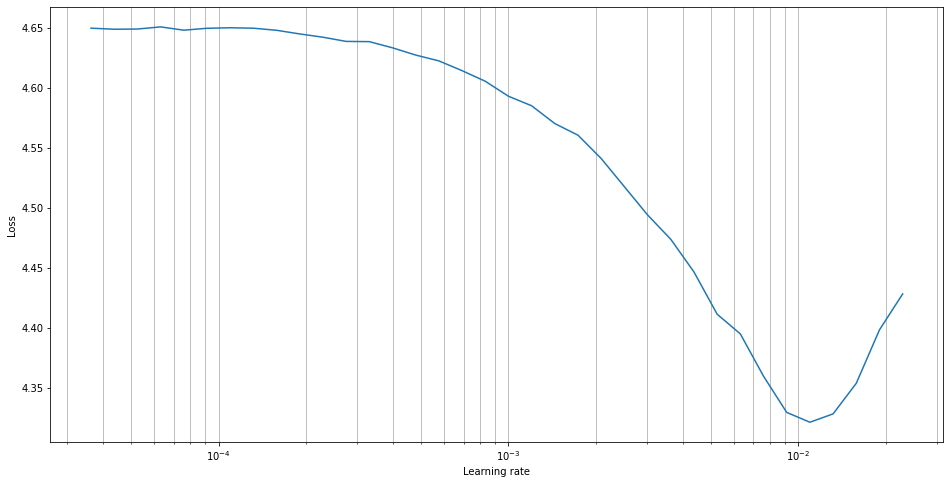

In [19]:
plot_lr_finder(lrs, losses, skip_start = 30, skip_end = 30)

In [26]:
FOUND_LR = 5e-3

params = [{'params': model.conv1.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.conv2.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.conv3.parameters(), 'lr': FOUND_LR / 10},
          {'params': model.inception3a.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.inception3b.parameters(), 'lr': FOUND_LR / 8},
          {'params': model.inception4a.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.inception4b.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.inception4c.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.inception4d.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.inception4e.parameters(), 'lr': FOUND_LR / 4},
          {'params': model.inception5a.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.inception5b.parameters(), 'lr': FOUND_LR / 2},
          {'params': model.fc.parameters(), 'lr': FOUND_LR / 1}]

optimizer = optim.Adam(params, lr = FOUND_LR)

In [28]:
EPOCHS = 10
STEPS_PER_EPOCH = len(train_dataloader)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]
scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

###4. Training

In [30]:
def calculate_topk_accuracy(y_pred, y, k = 5):
  with torch.no_grad():
    batch_size = y.shape[0]
    _, top_pred = y_pred.topk(k, 1)
    top_pred = top_pred.t()
    correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
    correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
    correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
    acc_1 = correct_1 / batch_size
    acc_k = correct_k / batch_size
  return acc_1, acc_k

In [34]:
def train(model, dataloader, optimizer, loss_fn, scheduler, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for (x, y) in tqdm(dataloader, desc="Training", leave=False):
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x) # model.requires_grad == True
        
        loss = loss_fn(y_pred, y)
                
        loss.backward()
        
        optimizer.step()
        
        scheduler.step() # update LRs

        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(dataloader)
    epoch_acc_1 /= len(dataloader)
    epoch_acc_5 /= len(dataloader)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [35]:
def evaluate(model, dataloader, loss_fn, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in tqdm(dataloader, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = loss_fn(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(dataloader)
    epoch_acc_1 /= len(dataloader)
    epoch_acc_5 /= len(dataloader)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [36]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
best_valid_loss = float('inf')

for epoch in trange(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_dataloader, optimizer, loss_fn, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_dataloader, loss_fn, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/704 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 4m 51s
	Train Loss: 2.042 | Train Acc @1:  50.78% | Train Acc @5:  79.07%
	Valid Loss: 1.203 | Valid Acc @1:  65.82% | Valid Acc @5:  91.38%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 4m 57s
	Train Loss: 1.378 | Train Acc @1:  60.96% | Train Acc @5:  89.07%
	Valid Loss: 1.481 | Valid Acc @1:  59.10% | Valid Acc @5:  87.72%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 4m 59s
	Train Loss: 1.299 | Train Acc @1:  63.15% | Train Acc @5:  89.87%
	Valid Loss: 1.476 | Valid Acc @1:  60.56% | Valid Acc @5:  89.20%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 4m 56s
	Train Loss: 1.051 | Train Acc @1:  69.14% | Train Acc @5:  93.10%
	Valid Loss: 1.173 | Valid Acc @1:  67.11% | Valid Acc @5:  91.63%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 4m 51s
	Train Loss: 0.843 | Train Acc @1:  74.45% | Train Acc @5:  95.28%
	Valid Loss: 1.094 | Valid Acc @1:  70.13% | Valid Acc @5:  92.54%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 4m 50s
	Train Loss: 0.662 | Train Acc @1:  79.57% | Train Acc @5:  96.98%
	Valid Loss: 0.895 | Valid Acc @1:  75.42% | Valid Acc @5:  94.50%


Training:   0%|          | 0/704 [00:00<?, ?it/s]

###5. Examination

At examining phase, we will accomplish these following steps sequentially: 
* Calculate Test Loss & Test Acc
* Plot the confusion matrix of the test set
* Plot the most confident incorrect predictions
* Visualize the features of intermediate and output layers (PCA, t-SNE)
* Generate fake random input images with 100% confidence.
* Visualize feature maps sujected to particular filters.
* Visualize the filters themselves.

####Test Loss & Test Acc

In [ ]:
model.load_state_dict(torch.load('tut5-model.pt'))

test_loss, test_acc = evaluate(model, test_dataloader, loss_fn, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

####Confusion Matrix

In [ ]:
def get_predictions(model, iterator):

  model.eval()

  images = []
  labels = []
  probs = []

  with torch.no_grad():

    for (x, y) in iterator:

      x = x.to(device)

      y_pred, _ = model(x)

      y_prob = F.softmax(y_pred, dim = -1)
      top_pred = y_prob.argmax(1, keepdim = True)

      images.append(x.cpu())
      labels.append(y.cpu())
      probs.append(y_prob.cpu())

  images = torch.cat(images, dim = 0)
  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)

  return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_dataloader)

In [ ]:
pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)
  cm = confusion_matrix(labels, pred_labels)
  cm = ConfusionMatrixDisplay(cm, display_labels=classes)
  cm.plot(values_format='d', cmap='Blues', ax=ax)
  plt.xticks(rotation=20)

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)

####Most Confident Incorrect Predictions

In [ ]:
corrects = torch.eq(labels, pred_labels)

In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
  if not correct:
    incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key=lambda x: torch.max(x[2], dim=0).values)

In [ ]:
def plot_most_incorrect(incorrect, classes, n_images, normalize=True):

  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure(figsize=(25, 20))

  for i in range(rows*cols):

    ax = fig.add_subplot(rows, cols, i+1)

    image, true_label, probs = incorrect[i]
    image = image.permute(1, 2, 0)
    true_prob = probs[true_label]
    incorrect_prob, incorrect_label = torch.max(probs, dim=0)
    true_class = classes[true_label]
    incorrect_class = classes[incorrect_label]

    if normalize:
      image = normalize_image(image)

    ax.imshow(image.cpu().numpy())
    ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n'
                 f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
    ax.axis('off')

  fig.subplots_adjust(hspace=0.4)

In [ ]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

####Output Layer's Features Visualization